In [ ]:
!pip install cssselect stanza
!apt install fonts-nanum

## 웹 스크래핑

In [1]:
import requests
import lxml.html
import pandas as pd

In [2]:
query = '인공지능'

In [9]:
href = []
for page in range(1, 3):
    url = f'https://search.daum.net/search?w=news&nil_search=btn&DA=NTB&enc=utf8&cluster=y&cluster_page=1&q={query}&p={page}'
    res = requests.get(url.format(page))
    root = lxml.html.fromstring(res.text)
    for link in root.cssselect('span.f_nb a'):
        href.append(link.attrib['href'])

In [13]:
import tqdm

In [14]:
articles = []
for h in tqdm.tqdm_notebook(href):
    res = requests.get(h)
    root = lxml.html.fromstring(res.text)
    for article in root.cssselect('.article_view'):
        articles.append(article.text_content())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


## 형태소 분석 및 단어문서행렬

In [16]:
import stanza

In [17]:
stanza.download('ko')

2020-07-04 04:47:15 INFO: Downloading default packages for language: ko (Korean)...
2020-07-04 04:47:33 INFO: Finished downloading models and saved to /root/stanza_resources.


In [18]:
nlp = stanza.Pipeline('ko')

2020-07-04 04:47:33 INFO: Loading these models for language: ko (Korean):
| Processor | Package |
-----------------------
| tokenize  | kaist   |
| pos       | kaist   |
| lemma     | kaist   |
| depparse  | kaist   |

2020-07-04 04:47:33 INFO: Use device: cpu
2020-07-04 04:47:33 INFO: Loading: tokenize
2020-07-04 04:47:33 INFO: Loading: pos
2020-07-04 04:47:34 INFO: Loading: lemma
2020-07-04 04:47:35 INFO: Loading: depparse
2020-07-04 04:47:36 INFO: Done loading processors!


In [42]:
def extract_noun(text):
    doc = nlp(text)
    for sentence in doc.sentences:
        for word in sentence.words:
            lemma = word.lemma.split('+')
            xpos = word.xpos.split('+')
            for tok, pos in zip(lemma, xpos):
                if pos.startswith('n') and len(tok) > 1:
                    yield tok

In [20]:
list(extract_noun('편의점에서 커피를 샀다.'))

['편의점', '커피']

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=100, tokenizer=extract_noun)

In [44]:
tdm = cv.fit_transform(articles)

In [45]:
word_count = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat
})

In [46]:
word_count.sort_values('빈도', ascending=False).head()

,단어,빈도
71,인공,172
80,지능,153
74,제공,42
44,서비스,40
12,광주,38


## 단어 구름

In [27]:
from wordcloud import WordCloud

In [39]:
wc = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
               background_color='white',
               max_words=50,
               width=400, height=300)

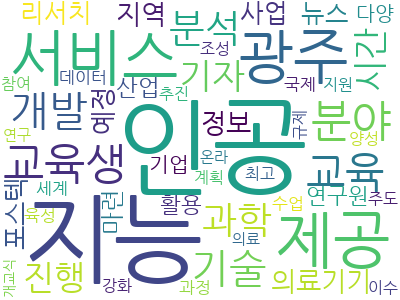

In [47]:
count_dic = word_count.set_index('단어')['빈도'].to_dict()
cloud = wc.generate_from_frequencies(count_dic)
cloud.to_image()

In [48]:
cloud.to_file('word_cloud.png')